In [2]:
!pip install torch torchvision livelossplot wandb torchtyping

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 16.0 MB/s eta 0:00:0000:0100:01
  Using cached torchtyping-0.1.4-py3-none-any.whl (17 kB)
  Using cached click-8.1.3-py3-none-any.whl (96 kB)
  Using cached GitPython-3.1.31-py3-none-any.whl (184 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 kB 7.0 MB/s eta 0:00:00
  Using cached docker_pycreds-0.4.0-py2.py3-none-any.whl (9.0 kB)
  Using cached pathtools-0.1.2.tar.gz (11 kB)
  Preparing metadata (setup.py) ... done
  Using cached appdirs-1.4.4-py2.py3-none-any.whl (9.6 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 397.2/397.2 kB 10.4 MB/s eta 0:00:00
  Using cached gitdb-4.0.10-py3-none-any.whl (62 kB)
  Using cached smmap-5.0.0-py3-none-any.whl (24 kB)
  DEPRECATION: pathtools is being installed using the legacy 'setup.py install' method, because it does not have a 'pyproject.toml' and the 'wheel' package is not installed. pip 23.1 will enforce this behaviour change. A possible replacement is to enable the '--us

## Libraries

In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from livelossplot import PlotLosses


## Helper function

In [5]:
def test_model(model, loss_fn, test_loader, device):
    with model.eval():

        loss = 0.
        num_correct = 0.
        for batch_idx, (x, y) in enumerate(test_loader):
            x, y = x.to(device), y.to(device)
            y_pred = model(x)
            loss += loss_fn(y_pred, y).item()
            _, predicted = torch.max(y_pred.data, 1)
            num_correct += (predicted == y).sum().item()

        model.train()
        loss /= len(test_loader.dataset)
        num_correct /= len(test_loader.dataset)
        
        return loss, num_correct

## Single-layer neural network

This an unmodified mnist learner

In [7]:
device = torch.device("cpu") # Uncomment this to run on CPU
# device = torch.device("cuda:0") # Uncomment this to run on GPU

def create_dataset(x, y):
    xt = torch.from_numpy(x).view(len(x), -1)
    yt = torch.from_numpy(y).long()
    return TensorDataset(xt, yt)

model = nn.Sequential()
model.add_module('fc1', nn.Linear(784, 10, bias=True))
model.to(device)

data = np.load('mnist.npz')
train_set = create_dataset(data['train_x'], data['train_y'])
train_loader = DataLoader(train_set, batch_size=256, shuffle=True)

loss_fn = nn.CrossEntropyLoss(size_average=False)
optimizer = optim.SGD(model.parameters(), lr=0.001)

for t in range(100):
    # Training loop for mini-batches
    for batch_idx, (x, y) in enumerate(train_loader):
        # Make predictions with the current parameters.
        x, y = x.to(device), y.to(device)
        y_pred = model(x)
        
        # Compute the loss value.
        loss = loss_fn(y_pred, y)

        # Update the parameters.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

FileNotFoundError: [Errno 2] No such file or directory: 'mnist.npz'

In [8]:
device = torch.device("cpu") # Uncomment this to run on CPU
# device = torch.device("cuda:0") # Uncomment this to run on GPU

model = nn.Sequential()
model.add_module('fc1', nn.Linear(784, 10, bias=True))
print(model)
model.to(device)

data = np.load('mnist.npz')
train_set = create_dataset(data['train_x'], data['train_y'])
test_set = create_dataset(data['test_x'], data['test_y'])
train_loader = DataLoader(train_set, batch_size=256, shuffle=True)
test_loader = DataLoader(test_set, batch_size=128)

loss_fn = nn.CrossEntropyLoss(size_average=False)
optimizer = optim.SGD(model.parameters(), lr=0.001)

liveloss = PlotLosses()
for t in range(100):
    train_loss = 0.
    train_correct = 0
    
    # Training loop for mini-batches
    for batch_idx, (x, y) in enumerate(train_loader):
        # Make predictions with the current parameters.
        x, y = x.to(device), y.to(device)
        y_pred = model(x)
        _, predicted = torch.max(y_pred.data, 1)
        train_correct += (predicted == y).sum().item()
        
        # Compute the loss value.
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # Update the parameters.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # Compute the average loss and accuracy.
    train_loss /= len(train_loader.dataset)
    train_correct /= float(len(train_loader.dataset))
    
    # Evaluate the model on the test set.
    test_loss, test_correct = test_model(model, loss_fn, test_loader, device)

    # Visualize the loss and accuracy values.
    liveloss.update({
        'log loss': train_loss,
        'val_log loss': test_loss,
        'accuracy': train_correct,
        'val_accuracy': test_correct,
    })
    liveloss.draw()

print('Accuracy: {:.4f} (test), {:.4f} (train)'.format(test_correct, train_correct))

Sequential(
  (fc1): Linear(in_features=784, out_features=10, bias=True)
)


FileNotFoundError: [Errno 2] No such file or directory: 'mnist.npz'

# START OF IDEA: Introduction of new digits in training

The section aims to see if introducing new digits later in the Epoch gives discontinuous boosts in peformance. I expect it shouldn't, since if we have the model say learn just 0 and 1 in the first half of training, then introduce the number 2, the parameters will be fitted only to (0,1) and do terrible on 2, so I expect a massive dip in accuracy in the middle, then some recovery at the end once it's seen some 0,1,2s but nowhere near the 90%+ as if we just did all 10 from the start. It's highly possible I may have misunderstood the setup, since I don't see how this could give a phase transition in decrease of loss. 

The code below is simply testing the filter digit function does as expected

In [ ]:
## This is just checking that the data filter works 

def filter_mnist_by_digits(mnist_dataset, digits_to_keep):
    filtered_images = []
    filtered_labels = []

    for i in range(len(mnist_dataset)):
        image, label = mnist_dataset[i]
        if label in digits_to_keep:
            filtered_images.append(image)
            filtered_labels.append(label)

    return filtered_images, filtered_labels

# Load MNIST dataset
mnist_train = MNIST('./data', train=True, download=True, transform=transforms.ToTensor())
mnist_test = MNIST('./data', train=False, download=True, transform=transforms.ToTensor())

# Filter the dataset for specific digits
digits_to_keep = [0, 1, 2]
train_images, train_labels = filter_mnist_by_digits(mnist_train, digits_to_keep)
test_images, test_labels = filter_mnist_by_digits(mnist_test, digits_to_keep)

# Checking expected amount survives the cleansing
print(f"Number of filtered train images: {len(train_images)}")
print(f"Number of filtered train labels: {len(train_labels)}")
print(f"Number of filtered test images: {len(test_images)}")
print(f"Number of filtered test labels: {len(test_labels)}")
print(train_labels)

Number of filtered train images: 18623
Number of filtered train labels: 18623
Number of filtered test images: 3147
Number of filtered test labels: 3147
[0, 1, 2, 1, 1, 1, 2, 0, 1, 1, 2, 2, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 2, 1, 1, 0, 2, 0, 0, 1, 1, 1, 1, 0, 2, 1, 1, 0, 2, 0, 0, 2, 0, 2, 1, 1, 1, 2, 1, 0, 2, 2, 0, 2, 1, 1, 2, 2, 1, 2, 2, 2, 0, 2, 1, 1, 1, 0, 1, 0, 0, 1, 2, 0, 2, 1, 0, 1, 0, 2, 0, 0, 1, 0, 1, 2, 2, 0, 2, 2, 1, 1, 1, 2, 0, 1, 0, 0, 0, 2, 1, 1, 1, 2, 2, 0, 2, 0, 2, 1, 2, 1, 1, 1, 1, 0, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 1, 1, 1, 0, 2, 1, 1, 2, 1, 0, 0, 2, 0, 0, 1, 2, 1, 2, 1, 0, 0, 1, 1, 2, 0, 0, 0, 1, 1, 2, 0, 1, 2, 2, 1, 0, 1, 1, 2, 1, 1, 1, 2, 0, 0, 0, 0, 2, 1, 1, 1, 0, 2, 2, 1, 1, 2, 1, 2, 2, 2, 2, 1, 1, 0, 0, 2, 1, 2, 2, 1, 0, 0, 1, 1, 0, 1, 2, 0, 1, 1, 0, 2, 2, 1, 2, 0, 2, 0, 2, 0, 0, 0, 0, 1, 2, 2, 1, 1, 2, 2, 0, 1, 2, 2, 1, 0, 0, 1, 1, 0, 2, 2, 2, 2, 0, 1, 0, 0, 1, 1, 2, 0, 1, 1, 0, 1, 0, 0, 2, 2, 1, 2, 2, 0, 1, 0, 2, 1, 1, 1, 2, 0, 2, 0, 0, 2, 2, 2, 0, 1, 1, 0, 2

Now we check whether we still get good accuracy with only 0, 1 and 2 in the dataset


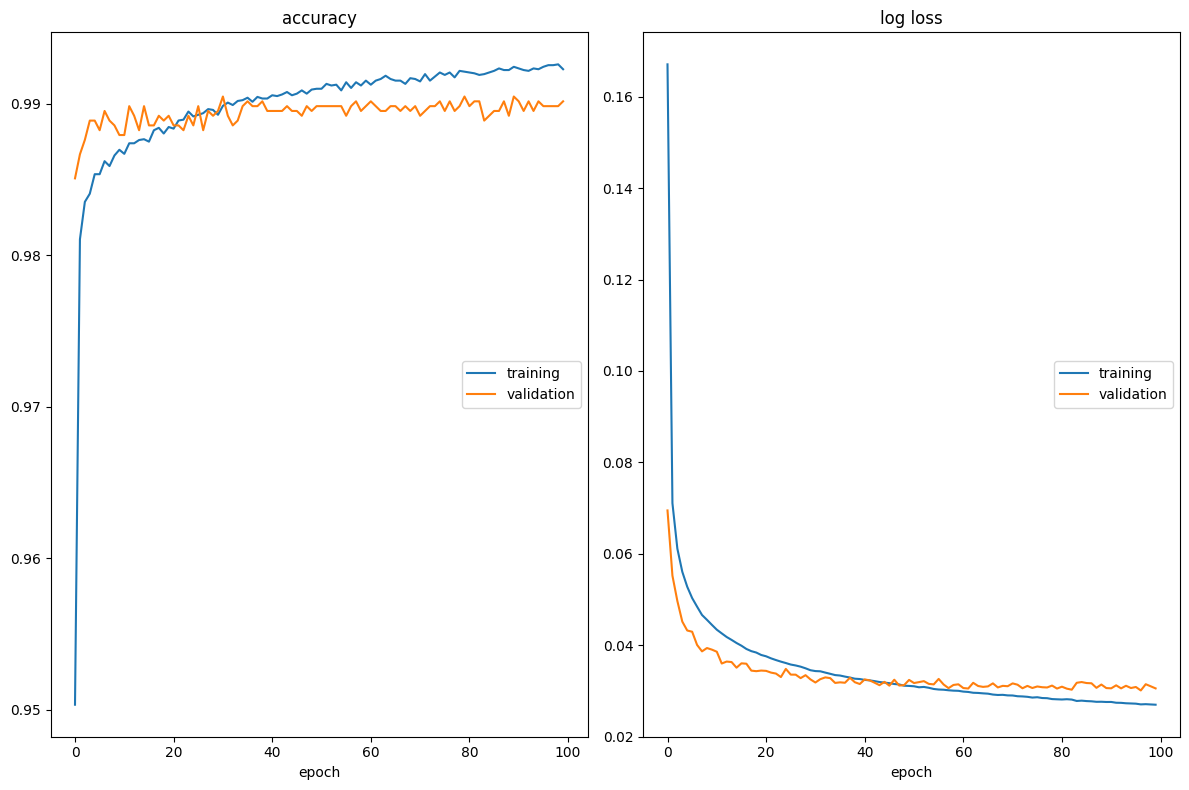

accuracy
	training         	 (min:    0.950, max:    0.993, cur:    0.992)
	validation       	 (min:    0.985, max:    0.990, cur:    0.990)
log loss
	training         	 (min:    0.027, max:    0.167, cur:    0.027)
	validation       	 (min:    0.030, max:    0.069, cur:    0.031)
Accuracy: 0.9901 (test), 0.9923 (train)


In [ ]:
#device = torch.device("cpu") # Uncomment this to run on CPU
device = torch.device("cuda:0") # Uncomment this to run on GPU

def create_dataset(images, labels):
    xt = torch.stack(images).view(len(images), -1)
    yt = torch.tensor(labels).long()
    return TensorDataset(xt, yt)

model = nn.Sequential()
model.add_module('fc1', nn.Linear(784, 10, bias=True))
model.to(device)

# Filter the dataset for specific digits
digits_to_keep = [0, 1, 2]
train_images, train_labels = filter_mnist_by_digits(mnist_train, digits_to_keep)
test_images, test_labels = filter_mnist_by_digits(mnist_test, digits_to_keep)

train_set = create_dataset(train_images, train_labels)
test_set = create_dataset(test_images, test_labels)

# Load filtered data in
train_loader = DataLoader(train_set, batch_size=256, shuffle=True)
test_loader = DataLoader(test_set, batch_size=128)

loss_fn = nn.CrossEntropyLoss(size_average=False)
optimizer = optim.SGD(model.parameters(), lr=0.001)

liveloss = PlotLosses()

for t in range(100):
    train_loss = 0.
    train_correct = 0
    
    # Training loop for mini-batches
    for batch_idx, (x, y) in enumerate(train_loader):
        # Make predictions with the current parameters.
        x, y = x.to(device), y.to(device)
        y_pred = model(x)
        _, predicted = torch.max(y_pred.data, 1)
        train_correct += (predicted == y).sum().item()
        
        # Compute the loss value.
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # Update the parameters.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # Compute the average loss and accuracy.
    train_loss /= len(train_loader.dataset)
    train_correct /= float(len(train_loader.dataset))
    
    # Evaluate the model on the test set.
    test_loss, test_correct = test_model(model, loss_fn, test_loader, device)

    # Visualize the loss and accuracy values.
    liveloss.update({
        'log loss': train_loss,
        'val_log loss': test_loss,
        'accuracy': train_correct,
        'val_accuracy': test_correct,
    })
    liveloss.draw()

print('Accuracy: {:.4f} (test), {:.4f} (train)'.format(test_correct, train_correct))

So as we can see we still get good accuracy with less digits, althought there appears to be much more variation in the accuracy which was not expected, and that it takes longer to get to a good accuracy which doesnt make much sense to me. Now we will try to train this model to learn on 0s and 1s only, then we introduce 2 halfway into the second half of training (Epoch 50) to see if there is discontinuity in performance

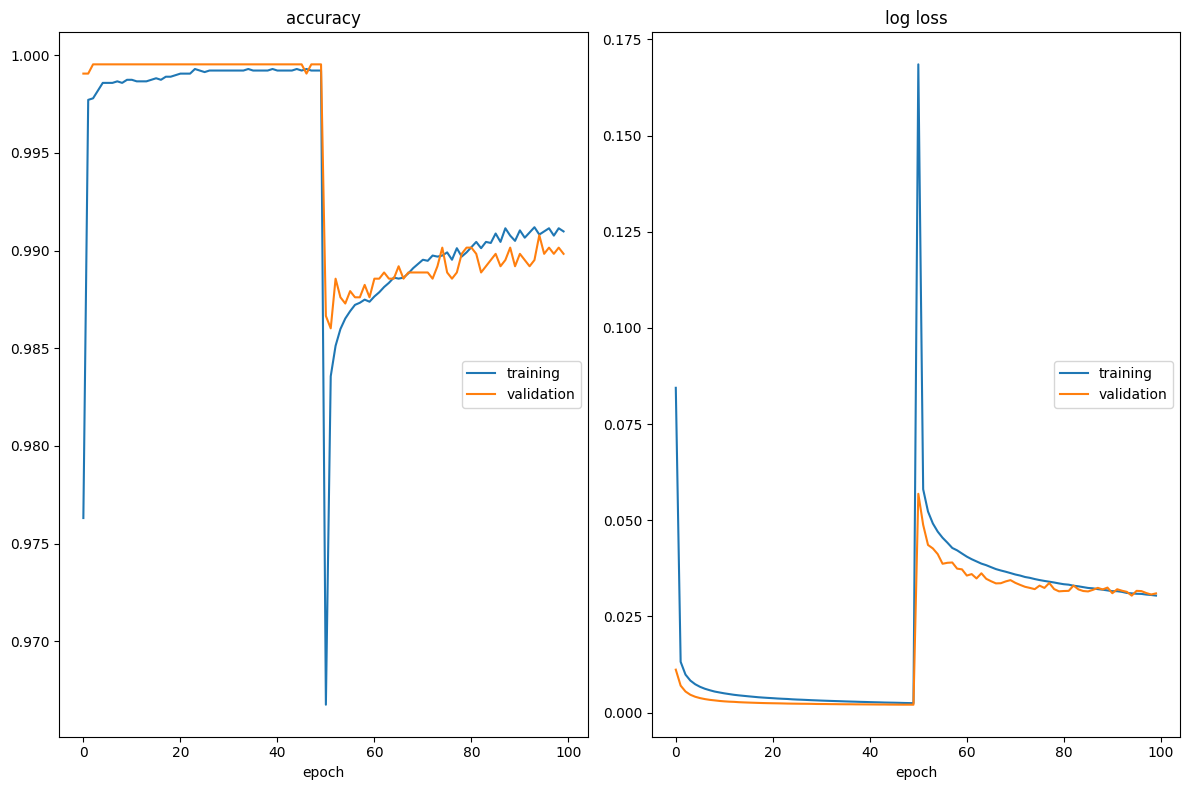

accuracy
	training         	 (min:    0.967, max:    0.999, cur:    0.991)
	validation       	 (min:    0.986, max:    1.000, cur:    0.990)
log loss
	training         	 (min:    0.002, max:    0.168, cur:    0.030)
	validation       	 (min:    0.002, max:    0.057, cur:    0.031)
Accuracy: 0.9898 (test), 0.9910 (train)


In [ ]:
model = nn.Sequential()
model.add_module('fc1', nn.Linear(784, 10, bias=True))
model.to(device)

# Filter the dataset for specific digits
digits_to_keep_1 = [0, 1]
train_images_1, train_labels_1 = filter_mnist_by_digits(mnist_train, digits_to_keep_1)
test_images_1, test_labels_1 = filter_mnist_by_digits(mnist_test, digits_to_keep_1)

train_set_1 = create_dataset(train_images_1, train_labels_1)
test_set_1 = create_dataset(test_images_1, test_labels_1)

digits_to_keep_2 = [0, 1, 2]
train_images_2, train_labels_2 = filter_mnist_by_digits(mnist_train, digits_to_keep_2)
test_images_2, test_labels_2 = filter_mnist_by_digits(mnist_test, digits_to_keep_2)

train_set_2 = create_dataset(train_images_2, train_labels_2)
test_set_2 = create_dataset(test_images_2, test_labels_2)

# Load filtered data in
#train_loader = DataLoader(train_set, batch_size=256, shuffle=True)
#test_loader = DataLoader(test_set, batch_size=128)

loss_fn = nn.CrossEntropyLoss(size_average=False)
optimizer = optim.SGD(model.parameters(), lr=0.001)

liveloss = PlotLosses()

for t in range(100):
    # Set the digits for the current epoch
    if t < 50:
        #digits_to_keep = [0, 1]
        train_loader = DataLoader(train_set_1, batch_size=256, shuffle=True)
        test_loader = DataLoader(test_set_1, batch_size=128)
    else:
        #digits_to_keep = [0, 1, 2]
        train_loader = DataLoader(train_set_2, batch_size=256, shuffle=True)
        test_loader = DataLoader(test_set_2, batch_size=128)

    train_loss = 0.
    train_correct = 0

    # Training loop for mini-batches
    for batch_idx, (x, y) in enumerate(train_loader):
        # Make predictions with the current parameters.
        x, y = x.to(device), y.to(device)
        y_pred = model(x)
        _, predicted = torch.max(y_pred.data, 1)
        train_correct += (predicted == y).sum().item()

        # Compute the loss value.
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # Update the parameters.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Compute the average loss and accuracy.
    train_loss /= len(train_loader.dataset)
    train_correct /= float(len(train_loader.dataset))

    # Evaluate the model on the test set.
    test_loss, test_correct = test_model(model, loss_fn, test_loader, device)

    # Visualize the loss and accuracy values.
    liveloss.update({
        'log loss': train_loss,
        'val_log loss': test_loss,
        'accuracy': train_correct,
        'val_accuracy': test_correct,
    })
    liveloss.draw()

print('Accuracy: {:.4f} (test), {:.4f} (train)'.format(test_correct, train_correct))

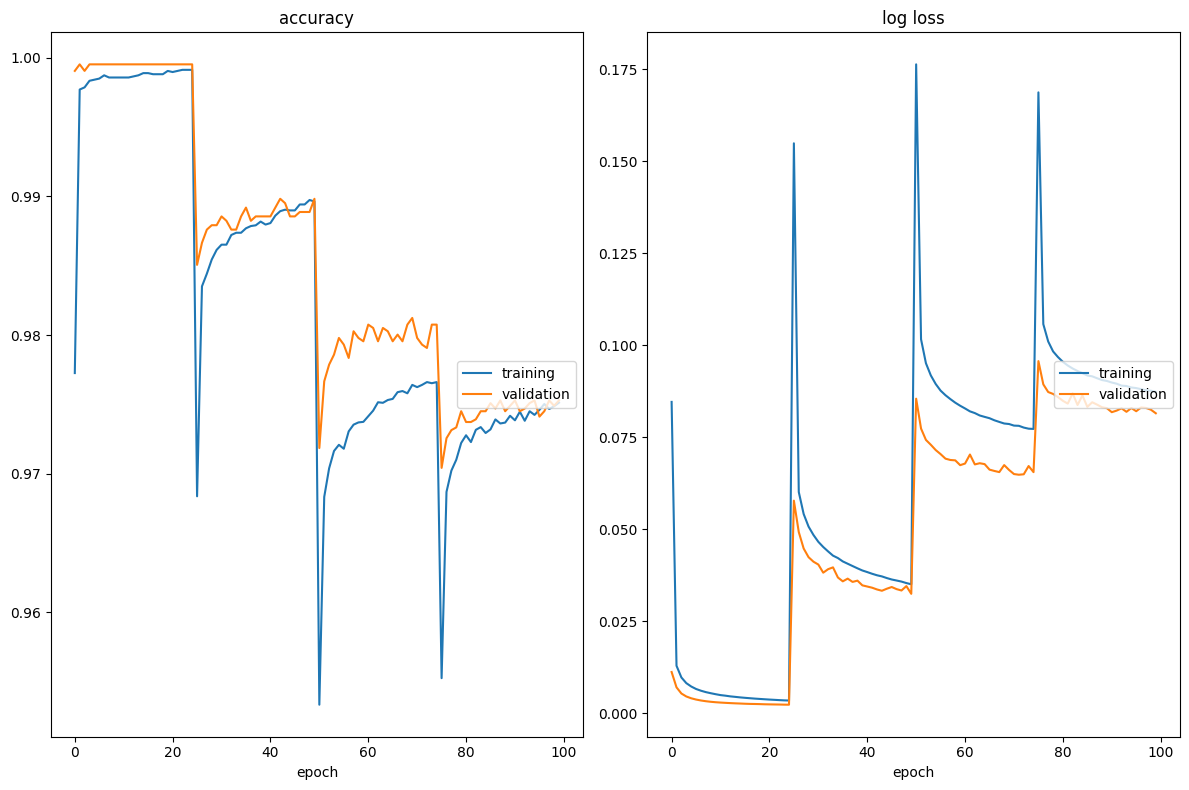

accuracy
	training         	 (min:    0.953, max:    0.999, cur:    0.975)
	validation       	 (min:    0.970, max:    1.000, cur:    0.975)
log loss
	training         	 (min:    0.003, max:    0.176, cur:    0.087)
	validation       	 (min:    0.002, max:    0.096, cur:    0.081)
Accuracy: 0.9753 (test), 0.9751 (train)


In [ ]:
model = nn.Sequential()
model.add_module('fc1', nn.Linear(784, 10, bias=True))
model.to(device)

# Filter the dataset for specific digits (Sorry its not in a loop)
digits_to_keep_1 = [0, 1]
train_images_1, train_labels_1 = filter_mnist_by_digits(mnist_train, digits_to_keep_1)
test_images_1, test_labels_1 = filter_mnist_by_digits(mnist_test, digits_to_keep_1)

train_set_1 = create_dataset(train_images_1, train_labels_1)
test_set_1 = create_dataset(test_images_1, test_labels_1)

digits_to_keep_2 = [0, 1, 2]
train_images_2, train_labels_2 = filter_mnist_by_digits(mnist_train, digits_to_keep_2)
test_images_2, test_labels_2 = filter_mnist_by_digits(mnist_test, digits_to_keep_2)

train_set_2 = create_dataset(train_images_2, train_labels_2)
test_set_2 = create_dataset(test_images_2, test_labels_2)

digits_to_keep_3 = [0, 1, 2, 3]
train_images_3, train_labels_3 = filter_mnist_by_digits(mnist_train, digits_to_keep_3)
test_images_3, test_labels_3 = filter_mnist_by_digits(mnist_test, digits_to_keep_3)

train_set_3 = create_dataset(train_images_3, train_labels_3)
test_set_3 = create_dataset(test_images_3, test_labels_3)

digits_to_keep_4 = [0, 1, 2, 3, 4]
train_images_4, train_labels_4 = filter_mnist_by_digits(mnist_train, digits_to_keep_4)
test_images_4, test_labels_4 = filter_mnist_by_digits(mnist_test, digits_to_keep_4)

train_set_4 = create_dataset(train_images_4, train_labels_4)
test_set_4 = create_dataset(test_images_4, test_labels_4)

loss_fn = nn.CrossEntropyLoss(size_average=False)
optimizer = optim.SGD(model.parameters(), lr=0.001)

liveloss = PlotLosses()

for t in range(100):
    # Set the digits for the current epoch
    if t < 25:
        #digits_to_keep = [0, 1]
        train_loader = DataLoader(train_set_1, batch_size=256, shuffle=True)
        test_loader = DataLoader(test_set_1, batch_size=128)
    elif t < 50:
        train_loader = DataLoader(train_set_2, batch_size=256, shuffle=True)
        test_loader = DataLoader(test_set_2, batch_size=128)
    elif t < 75:
        train_loader = DataLoader(train_set_3, batch_size=256, shuffle=True)
        test_loader = DataLoader(test_set_3, batch_size=128)   
    else:
        #digits_to_keep = [0, 1, 2]
        train_loader = DataLoader(train_set_4, batch_size=256, shuffle=True)
        test_loader = DataLoader(test_set_4, batch_size=128)

    train_loss = 0.
    train_correct = 0

    # Training loop for mini-batches
    for batch_idx, (x, y) in enumerate(train_loader):
        # Make predictions with the current parameters.
        x, y = x.to(device), y.to(device)
        y_pred = model(x)
        _, predicted = torch.max(y_pred.data, 1)
        train_correct += (predicted == y).sum().item()

        # Compute the loss value.
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # Update the parameters.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Compute the average loss and accuracy.
    train_loss /= len(train_loader.dataset)
    train_correct /= float(len(train_loader.dataset))

    # Evaluate the model on the test set.
    test_loss, test_correct = test_model(model, loss_fn, test_loader, device)

    # Visualize the loss and accuracy values.
    liveloss.update({
        'log loss': train_loss,
        'val_log loss': test_loss,
        'accuracy': train_correct,
        'val_accuracy': test_correct,
    })
    liveloss.draw()

print('Accuracy: {:.4f} (test), {:.4f} (train)'.format(test_correct, train_correct))